# Joint spectrum fit with systematics

In this notebook, we re-execute the joint spectrum fit including systematics
on the per-instrument energy scales, as described in the paper and scripted
in ``joint_crab/fit_systematics.py``. Please see the paper for a description
of the likelihood function and parameters.

First we illustrate the effect of the energy scale on the spectral model.
After the fit, we show the parameter correlations, and we show a plot
illustrating the energy scale shifts for each instrument.

In [1]:
%matplotlib inline
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from multinorm import MultiNorm

from joint_crab.fit_models import Log10ParabolaEnergyScale
from joint_crab.fit_systematics import SystematicsSpectrumFit

## Energy scale shift

Let us see how the log-parabolic spectrum is modified by an energy scale shift of $\pm20\%$.

For negative energy scale factor `z` the spectrum is shifted to lower energies,
for positive `z` to higher energies.

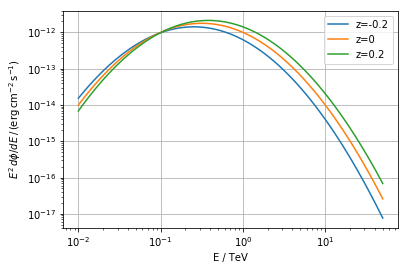

In [2]:
for z in [-0.2, 0, +0.2]:
    model = Log10ParabolaEnergyScale(z=z)
    model.plot([0.01, 50] * u.TeV, energy_power=2, label=f"z={z}")

plt.legend()
plt.xlabel("E / TeV")
plt.ylabel(
    r"$E^2\,d\phi/dE\,/\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1})$"
)
plt.grid()

# Execute fit

Let's run the fit.
The ``delta`` values used are 15% for IACTs and 5% for Fermi-LAT.

In [3]:
SystematicsSpectrumFit.delta

{'fermi': 0.05, 'magic': 0.15, 'hess': 0.15, 'veritas': 0.15, 'fact': 0.15}

In [4]:
%%time

fit = SystematicsSpectrumFit()
result = fit.run()

CPU times: user 9.13 s, sys: 39.5 ms, total: 9.17 s
Wall time: 9.19 s


## Fit results

We use `MultiNorm` to have nice table representations of the values,
errors and parameter correlation matrix.

In [5]:
result

FitResult

	backend    : minuit
	method     : minuit
	success    : True
	nfev       : 594
	total stat : 441.23
	message    : Optimization terminated successfully.

In [6]:
t = result.model.parameters.to_table()
multi_norm = MultiNorm(
    mean=list(t["value"]),
    names=list(t["name"]),
    cov=result.model.parameters.covariance,
).drop(["reference"])

In [7]:
multi_norm.parameters

,mean,err
name,,
amplitude,3.880091e-11,3.536017e-12
alpha,2.510771e+00,3.763238e-02
beta,2.423330e-01,2.759517e-02
z_fermi,4.365007e-03,4.511147e-02
z_magic,-2.684315e-03,6.089172e-02
z_veritas,-5.560264e-02,6.427045e-02
z_fact,-1.029063e-01,6.579716e-02
z_hess,9.929812e-02,7.293912e-02


In [8]:
multi_norm.correlation

name,amplitude,alpha,beta,z_fermi,z_magic,z_veritas,z_fact,z_hess
name,,,,,,,,
amplitude,1.000000,-0.489970,0.192608,-0.400052,-0.814372,-0.759988,-0.794817,-0.867305
alpha,-0.489970,1.000000,0.626201,0.025503,0.252517,0.285266,0.620496,0.589589
beta,0.192608,0.626201,1.000000,0.042951,-0.214565,-0.190374,0.093339,0.010345
z_fermi,-0.400052,0.025503,0.042951,1.000000,0.440457,0.362461,0.293658,0.331468
z_magic,-0.814372,0.252517,-0.214565,0.440457,1.000000,0.646915,0.610670,0.680751
z_veritas,-0.759988,0.285266,-0.190374,0.362461,0.646915,1.000000,0.581340,0.643209
z_fact,-0.794817,0.620496,0.093339,0.293658,0.610670,0.581340,1.000000,0.741487
z_hess,-0.867305,0.589589,0.010345,0.331468,0.680751,0.643209,0.741487,1.000000


## Plot

The spectral results with the modified likelihood are given in Figure 4 of the paper.

Here we plot the results for the energy-scale factors.

In [9]:
multi_norm.mean["z_fermi"]

0.004365007495221839

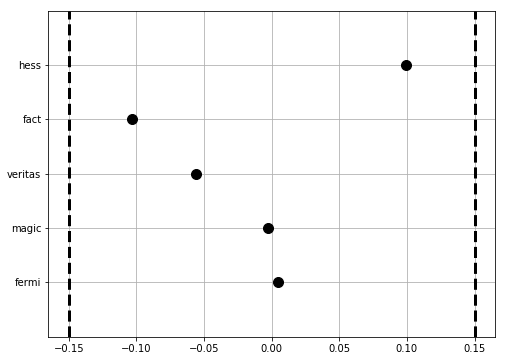

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

names = ["fermi", "magic", "veritas", "fact", "hess"]

for y, name in enumerate(names):
    x = multi_norm.mean[f"z_{name}"]
    ax.plot(x, y, ls="-", marker="o", ms=10, color="k")

ax.set_ylim([-1, 5])
ax.set_yticks(list(range(5)))
ax.set_yticklabels(names)
ax.grid()
ax.axvline(0.15, color="k", lw=3, ls="--")
ax.axvline(-0.15, color="k", lw=3, ls="--");